# Classification problem on the Twenty News Groups dataset

In this exercise, we'll use a simple <i>[bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model)</i> model of term frequencies to create feature vectors of the emails in the <i>twenty newsgroups</i> dataset and build a classifier to identify emails belonging to <i>computer related topics</i> and those which aren't.

More information on the <i>Twenty Newsgroups</i> dataset can be found on the [UCI website](http://kdd.ics.uci.edu/databases/20newsgroups/20newsgroups.html)

**Prerequisites:** 
* Load and preprocess the 20 newsgroups data set using the scripts in the 00_prepare_data_set folder of the repository

## Setup database connectivity

We'll reuse our module from the previous notebook (***`00_database_connectivity_setup.ipynb`***) to establish connectivity to the database

In [1]:
%run '00_database_connectivity_setup.ipynb'
%matplotlib inline
from IPython.display import display

/Users/shajek/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Your connection object is ***`conn`***:
1. Queries: You can run your queries using ***```psql.read_sql("""<YOUR SQL>""", conn)```***.
2. Create/Delete/Updates: You can run these statements using ***```psql.execute("""<YOUR SQL>""", conn)```***, followed by a ***```conn.commit()```*** command to ensure your transaction is committed. Otherwise your changes will be rolledback if you terminate your kernel.

If you created a new connection object (say to connect to a new cluster) as shown in the last section of `00_database_connectivity_setup.ipynb` notebook, use that connection object where needed.

## 1. Create a bag of words model with term-frequencies as the features

In [2]:
#UDF to compute term-frequency vector
sql = """
    drop function if exists YOUR_SCHEMA.tf_vectorize(float8[], text[], text[]);
    create or replace function YOUR_SCHEMA.tf_vectorize(
        tf_arr float8[],
        tokens_arr text[],
        vocabulary_arr text[]
    )
    returns float8[]
    as
    $$
        result = [0 for _ in xrange(len(vocabulary_arr))]
        idx_map = dict(map(lambda pr: reversed(pr), enumerate(vocabulary_arr)))
        tf_dict = dict(zip(tokens_arr, tf_arr))
        for key in tf_dict.keys():
            if idx_map.has_key(key):
                result[idx_map[key]] = tf_dict[key]
        return result
    $$language plpythonu;
"""
psql.execute(sql, conn)
conn.commit()

In [3]:
sql = """
    drop table if exists YOUR_SCHEMA.twenty_news_groups_bow cascade;
    create table YOUR_SCHEMA.twenty_news_groups_bow
    as
    (
        select
            doc_id,
            YOUR_SCHEMA.tf_vectorize(
                tf_arr,
                token_arr,
                vocab_arr
            ) as feature_vector
        from
            (
                select
                    doc_id,
                    array_agg(tf order by token) as tf_arr,
                    array_agg(token order by token) as token_arr
                from
                    YOUR_SCHEMA.twenty_news_groups_term_frequencies
                group by doc_id
            )t1,
            (
                select
                    array_agg(token order by token) as vocab_arr
                from 
                    YOUR_SCHEMA.twenty_news_groups_vocabulary
            )t2
    ) distributed randomly;
"""
psql.execute(sql, conn)
conn.commit()

## 2. Create train & test split    

In [4]:
sql = """
    -- Set the seed to ensure the random splits are repeatable
    -- This is important if you want to measure performance 
    -- of classifiers based by varying the "num_bits" parameter
    -- Note: You should run the setseed() statement and the following create temp table statement as a single
    -- transaction.
    select setseed(0.5);
    drop table if exists bow_vector_train_test_split cascade;
    create temp table bow_vector_train_test_split
    as
    (
        select
            t1.doc_id,
            t1.feature_vector,
            -- to create a binary classification problem
            -- consider the task as being able to predict if a document is related to computers or not            
            case 
                when t2.label ~* 'comp.*' then 1 
                else 0
            end as label,
            random() as splitter
        from
            YOUR_SCHEMA.twenty_news_groups_bow t1,
            YOUR_SCHEMA.twenty_news_groups t2
        where
            t1.doc_id = t2.doc_id
        order by
            doc_id
    ) distributed randomly;

    -- Training set
    drop table if exists YOUR_SCHEMA.bow_vector_training_set cascade;
    create table YOUR_SCHEMA.bow_vector_training_set
    as
    (
        select 
            doc_id,
            feature_vector,
            label
        from
            bow_vector_train_test_split
        where 
            splitter <= 0.75
    ) distributed randomly;

    -- Test set
    drop table if exists YOUR_SCHEMA.bow_vector_test_set cascade;
    create table YOUR_SCHEMA.bow_vector_test_set
    as
    (
        select 
            doc_id,
            feature_vector,
            label
        from
            bow_vector_train_test_split
        where 
            splitter > 0.75
    ) distributed randomly; 
"""
psql.execute(sql, conn)
conn.commit()

## 3. Train Classifier

In [ ]:
sql = """
    drop table if exists YOUR_SCHEMA.bow_vector_logregr_mdl;
    drop table if exists YOUR_SCHEMA.bow_vector_logregr_mdl_summary;
    select 
        madlib_1_10.logregr_train( 
            'YOUR_SCHEMA.bow_vector_training_set',
            'YOUR_SCHEMA.bow_vector_logregr_mdl',
            'label',
            'feature_vector',
            NULL,
            20,
            'irls'
    );
"""
psql.execute(sql, conn)
conn.commit()

In [9]:
psql.read_sql(
    """select * from YOUR_SCHEMA.bow_vector_logregr_mdl limit 10""",
    conn
)

,coef,log_likelihood,std_err,z_stats,p_values,odds_ratios,condition_no,num_rows_processed,num_missing_rows_skipped,num_iterations,variance_covariance
0,None,None,None,None,None,None,None,None,None,13,None


## 4. Score using the trained classifier 

In [6]:
sql = """
    drop table if exists YOUR_SCHEMA.bow_vector_prediction_results cascade;
    create table YOUR_SCHEMA.bow_vector_prediction_results
    as
    (
        select
            doc_id,
            label as actual_label,
            madlib.logregr_predict(
                coef,
                feature_vector
            ) as predicted_label,            
            madlib.logregr_predict_prob(
                coef,
                feature_vector
            ) as predicted_label_proba
        from
            YOUR_SCHEMA.bow_vector_logregr_mdl mdl,
            YOUR_SCHEMA.bow_vector_test_set test_set
    ) distributed randomly;
"""
psql.execute(sql, conn)
conn.commit()

## 5. Test ROC

In [7]:
sql = """
    select
        doc_id,
        actual_label,
        predicted_label,
        predicted_label_proba
    from
        YOUR_SCHEMA.bow_vector_prediction_results
"""
df = psql.read_sql(sql, conn)
df.head()

,doc_id,actual_label,predicted_label,predicted_label_proba
0,3,0,None,None
1,18,0,None,None
2,26,0,None,None
3,40,0,None,None
4,51,0,None,None


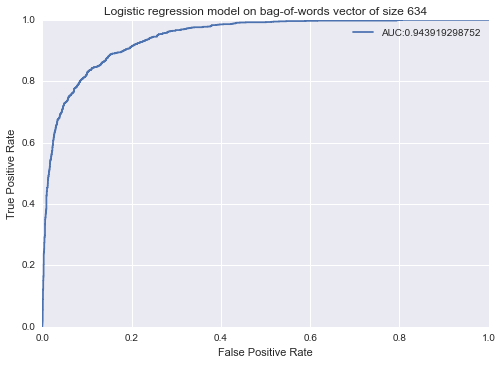

In [43]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
fpr, tpr, thresholds = metrics.roc_curve(
                            df['actual_label'].tolist(),
                            df['predicted_label_proba'].tolist(), 
                            pos_label=1
                        )
auc = metrics.auc(fpr, tpr)
rocdf = pd.DataFrame(np.transpose([fpr, tpr, thresholds]), columns = ['fpr','tpr','thresholds'])
rocdf.plot(x='fpr',y='tpr', label='AUC:{0}'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic regression model on bag-of-words vector of size {0}'.format(vocabulary_size))
plt.show()